In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from math import pi
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
sigmap = np.array([[0,1],[0,0]])
sigmam = np.array([[0,0],[1,0]])

def String(num_string):
    SOP = 1
    for ns, sid in enumerate(num_string):
        if sid == 0:
            OP = np.eye(2)
        elif sid==1:
            OP = sigmax
        elif sid==2:
            OP = sigmay
        elif sid==3:
            OP = sigmaz
        elif sid == 4:
            OP = sigmam
        elif sid == 5:
            OP = sigmap
        else:
            pass
        SOP = np.kron(OP,SOP)
    return SOP

def qtoclabel(num_string):
    stat_num = 0
    for ns, sid in enumerate(num_string):
        stat_num = stat_num + sid*(2**ns)
    return stat_num

def qubit_state(Num,ind):
    t0 = ind
    d = np.zeros(Num)
    for n in range(Num-1,0,-1):
        d[n] = np.int_(np.floor(t0/(2**n)))
        t0 = t0 - d[n]*2**n
    d[0] = np.remainder(ind,2)
    return d

In [3]:
### single-exciation terms are represented by an array with two elements with the first one denoting creation operaotr localtion
### and the second one for the annihilation location
def generate_Pstring(array,N):
    if array[0]!=array[1]:
        M = np.zeros([1,N],dtype=int)
        M[0,array[0]] = 4
        M[0,array[1]] = 5
        for n in range(np.min(array)+1,np.max(array),1):
            M[0,n] = 3
        sgn = np.array([1])
    else:
        M = np.zeros((2,N),dtype=int)
        M[1,array[0]]=3
        sgn = np.array([1/2,-1/2])
    return M, sgn

In [4]:
def generate_matrix_from_CA(array,N):
    ## here the even index of array is for the location of creation operator, and odd index for the annihilation operator
    L = len(array)
    Ne = np.int(L/2) # number of exciations
    ### get Pauli string arrays
    Pstr=[]
    Sgn_arr = []
    for n in range(Ne):
        A, B = generate_Pstring(np.array([array[2*n],array[2*n+1]]),N)
        Pstr.append(A)
        Sgn_arr.append(B)
    H1e = np.eye(2**N,2**N);
    for n in range(Ne):
        A = np.zeros((2**N,2**N),dtype=complex)
        for n1 in range(len(Sgn_arr[n])):
            A = A + String(Pstr[n][n1,:])*Sgn_arr[n][n1]
        H1e = np.dot(H1e,A)
    return H1e

def commutator(arr1,arr2):
    n = arr1[0]
    m = arr1[1]
    k = arr2[0]
    l = arr2[1]
    if n==m and m==k and k==l:
        return np.array([[]]), np.array([0])
    elif n==m and m==k and k!=l:
        return np.array([[n,l]]), np.array([1])
    elif n==m and m==l and l!=k:
        return np.array([[k,m]]), np.array([-1])
    elif n==k and k==l and n!=m:
        return np.array([[k,m]]), np.array([-1])
    elif m==k and k==l and n!=m:
        return np.array([[n,l]]), np.array([1])
    elif n==m and k==l and n!=k:
        return np.array([[]]), np.array([0])
    elif n==k and m==l and n!=m:
        return np.array([[]]), np.array([0])
    elif n==l and k==m and n!=k:
        return np.array([[n,n],[m,m]]), np.array([1,-1])
    elif n==m and m!=k and m!=l and k!=l:
        return np.array([[]]), np.array([0])
    elif n==k and n!=m and n!=l and m!=l:
        return np.array([[]]), np.array([0])
    elif n==l and n!=m and n!=k and m!=k:
        return np.array([[k,m]]), np.array([-1])
    elif m==k and m!=n and m!=l and n!=l:
        return np.array([[n,l]]), np.array([1])
    elif m==l and m!=n and m!=k and n!=k:
        return np.array([[]]), np.array([0])
    elif k==l and m!=l and n!=l and n!=m:
        return np.array([[]]), np.array([0])
    else:
        return np.array([[]]), np.array([0])

In [5]:
def get_commutator(Str1,Str2,N):
    L1 = len(Str1)
    Ne1 = np.int(L1/2) # number of exciations for the first string
    L2 = len(Str2)
    Ne2 = np.int(L2/2) # number of exciations for the first string
    ##### we focus on the case with at most two-excitations
    Mout = np.zeros((2**N,2**N),dtype=complex)
    if Ne1==1 and Ne2==1:
        M, sgn = commutator(Str1,Str2)
        Nout = len(sgn)
        for n in range(Nout):
            if sgn[0] != 0:
                CAM = generate_matrix_from_CA(M[n,:],N)
                Mout = Mout + CAM*sgn[n]
            else:
                pass
    elif Ne1==1 and Ne2==2:
        M1, sgn1 = commutator(Str1,Str2[0:2])
        M2, sgn2 = commutator(Str1,Str2[2:4])
        for n in range(len(sgn1)):
            if sgn1[n] != 0:
#                 print(M1[n,:],n)
#                 print(sgn1[n])
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] != 0:
#                 print(M2[n,:],n)
#                 print(sgn2[n])
                CAM0 = generate_matrix_from_CA(Str2[0:2],N)
                CAM1 = generate_matrix_from_CA(M2[n,:],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn2[n]
            else:
                pass
    elif Ne1==2 and Ne2==1:
        M1, sgn1 = commutator(Str1[0:2],Str2)
        M2, sgn2 = commutator(Str1[2:4],Str2)
        for n in range(len(sgn1)):
            if sgn1[n] !=0:
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str1[2:4],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] !=0:
                CAM0 = generate_matrix_from_CA(Str1[0:2],N)
                CAM1 = generate_matrix_from_CA(M2[n,:],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn2[n]
            else:
                pass
    elif Ne1==2 and Ne2==2:
        M1, sgn1 = commutator(Str1[0:2],Str2[0:2])
        M2, sgn2 = commutator(Str1[0:2],Str2[2:4])
        M3, sgn3 = commutator(Str1[2:4],Str2[0:2])
        M4, sgn4 = commutator(Str1[2:4],Str2[2:4])
        for n in range(len(sgn1)):
            if sgn1[n] != 0:
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                CAM2 = generate_matrix_from_CA(Str1[2:4],N)
                A1 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(A1,CAM2)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] != 0:
                CAM0 = generate_matrix_from_CA(M2[n,:],N)
                CAM1 = generate_matrix_from_CA(Str1[2:4],N)
                CAM2 = generate_matrix_from_CA(Str2[0:2],N)
                A2 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(CAM2,A2)*sgn2[n]
            else:
                pass
        for n in range(len(sgn3)):
            if sgn3[n] != 0:
                CAM0 = generate_matrix_from_CA(M3[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                CAM2 = generate_matrix_from_CA(Str1[0:2],N)
                A3 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(CAM2,A3)*sgn3[n]
            else:
                pass
        for n in range(len(sgn4)):
            if sgn4[n] != 0:
                CAM0 = generate_matrix_from_CA(M4[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[0:2],N)
                CAM2 = generate_matrix_from_CA(Str1[0:2],N)
                A4 = np.dot(CAM1,CAM0)
                Mout = Mout + np.dot(CAM2,A4)*sgn4[n]
            else:
                pass
    return Mout

In [6]:
### provide the CA array for the Pool operators for 4 sites

def pool_4site(n,nos):
    if n==0:
        CAarray = np.array([[0,1],[1,0]])
    elif n==1:
        CAarray = np.array([[0,2],[2,0]])
    elif n==2:
        CAarray = np.array([[0,3],[3,0]])
    elif n==3:
        CAarray = np.array([[1,2],[2,1]])
    elif n==4:
        CAarray = np.array([[1,3],[3,1]])
    elif n==5:
        CAarray = np.array([[2,3],[3,2]])
    elif n==6:
        CAarray = np.array([[0,1,2,3],[3,2,1,0]])
    elif n==7:
        CAarray = np.array([[0,2,1,3],[3,1,2,0]])
    elif n==8:
        CAarray = np.array([[0,3,1,2],[2,1,3,0]])
    elif n==9:
        CAarray = np.array([[0,1,3,2],[2,3,1,0]])
    elif n==10:
        CAarray = np.array([[0,2,3,1],[1,3,2,0]])
    elif n==11:
        CAarray = np.array([[0,3,2,1],[1,2,3,0]])
    else:
        pass
        
    if nos == 0:
        sgnM = np.array([1,-1])
    elif nos == 1:
        sgnM = np.array([1j,1j])
    else:
        pass
    return CAarray, sgnM

In [7]:
def get_commutator_with_bulk(CAarray,sgnM,t,N,array_bulk,sgn_bulk):
    OP = np.zeros((2**N,2**N),dtype=complex)
    ### obtained the operator matrix for the commutator between a pool operator and the hopping in bulk
    Nca = len(sgnM)
    Nbk = len(sgn_bulk)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Nbk):
            B = array_bulk[n2,:]
            coef = sgnM[n1]*sgn_bulk[n2]
            OP = OP + coef*get_commutator(A,B,N)*(-t/2)
    return OP

def get_commutator_with_onsite(CAarray,sgnM,M,N,array_on,sgn_on):
    OP = np.zeros((2**N,2**N),dtype=complex)
    ### obtained the operator matrix for the commutator between a pool operator and the on-site terms
    Nca = len(sgnM)
    Non = len(sgn_on)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Non):
            B = array_on[n2,:]
            coef = sgnM[n1]*sgn_on[n2]
            OP = OP + coef*get_commutator(A,B,N)*M
    return OP

def get_commutator_with_int(CAarray,sgnM,U,N,array_int,sgn_int):
    OP = np.zeros((2**N,2**N),dtype=complex)
    ### obtained the operator matrix for the commutator between a pool operator and the on-site terms
    Nca = len(sgnM)
    Non = len(sgn_int)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Non):
            B = array_int[n2,:]
            coef = sgnM[n1]*sgn_int[n2]
            OP = OP + coef*get_commutator(A,B,N)*U
    return OP
        
def get_commutator_with_bdy_xp(CAarray,sgnM,t,N,dkx,array_x1_bdy,sgn_x1_bdy):
    OP = np.zeros((2**N,2**N),dtype=complex)
    phxp = np.exp(1j*2*pi*dkx)
    ### obtained the operator matrix for the commutator between a pool operator and the boundary hopping along positive x
    Nca = len(sgnM)
    Nx1 = len(sgn_x1_bdy)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Nx1):
            B = array_x1_bdy[n2,:]
            coef = sgnM[n1]*sgn_x1_bdy[n2]
            OP = OP + coef*get_commutator(A,B,N)*(-t/2)*phxp
    return OP
            
def get_commutator_with_bdy_xm(CAarray,sgnM,t,N,dkx,array_x2_bdy,sgn_x2_bdy):
    OP = np.zeros((2**N,2**N),dtype=complex)
    phxm = np.exp(-1j*2*pi*dkx)
    ### obtained the operator matrix for the commutator between a pool operator and the boundary hopping along negative x
    Nca = len(sgnM)
    Nx2 = len(sgn_x2_bdy)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Nx2):
            B = array_x2_bdy[n2,:]
            coef = sgnM[n1]*sgn_x2_bdy[n2]
            OP = OP + coef*get_commutator(A,B,N)*(-t/2)*phxm
    return OP
            
def get_commutator_with_bdy_yp(CAarray,sgnM,t,N,dky,array_y1_bdy,sgn_y1_bdy):
    OP = np.zeros((2**N,2**N),dtype=complex)
    phyp = np.exp(1j*2*pi*dky)
    ### obtained the operator matrix for the commutator between a pool operator and the boundary hopping along positive y
    Nca = len(sgnM)
    Ny1 = len(sgn_y1_bdy)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Ny1):
            B = array_y1_bdy[n2,:]
            coef = sgnM[n1]*sgn_y1_bdy[n2]
            OP = OP + coef*get_commutator(A,B,N)*(-t/2)*phyp
    return OP

def get_commutator_with_bdy_ym(CAarray,sgnM,t,N,dky,array_y2_bdy,sgn_y2_bdy):
    OP = np.zeros((2**N,2**N),dtype=complex)
    phym = np.exp(-1j*2*pi*dky)
    ### obtained the operator matrix for the commutator between a pool operator and the boundary hopping along negative y
    Nca = len(sgnM)
    Ny2 = len(sgn_y2_bdy)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Ny2):
            B = array_y2_bdy[n2,:]
            coef = sgnM[n1]*sgn_y2_bdy[n2]
            OP = OP + coef*get_commutator(A,B,N)*(-t/2)*phym
    return OP

In [8]:
def get_OP_comm(n,nos,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy):
    Pl_str, Pl_sgn = pool_4site(n,nos)
    Out_bulk = get_commutator_with_bulk(Pl_str,Pl_sgn,t,N,array_bulk,sgn_bulk)
    Out_on = get_commutator_with_onsite(Pl_str,Pl_sgn,M,N,array_on,sgn_on)
    Out_int = get_commutator_with_int(Pl_str,Pl_sgn,U,N,array_int,sgn_int)
    Out_bdy_xp = get_commutator_with_bdy_xp(Pl_str,Pl_sgn,t,N,dkx,array_x1_bdy,sgn_x1_bdy)
    Out_bdy_xm = get_commutator_with_bdy_xm(Pl_str,Pl_sgn,t,N,dkx,array_x2_bdy,sgn_x2_bdy)
    Out_bdy_yp = get_commutator_with_bdy_yp(Pl_str,Pl_sgn,t,N,dky,array_y1_bdy,sgn_y1_bdy)
    Out_bdy_ym = get_commutator_with_bdy_ym(Pl_str,Pl_sgn,t,N,dky,array_y2_bdy,sgn_y2_bdy)
    OP = Out_bulk + Out_on +Out_int + Out_bdy_xp + Out_bdy_xm + Out_bdy_yp + Out_bdy_ym
    return OP

def det_OP_4site(nop,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
           array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,Psi):
    P = np.array([],dtype=float)
    Nop = np.array([],dtype=int)
    Sop = np.array([],dtype=int)
    for n in range(nop):
        if n < 6:
            ##### get the normal hopping
            OP = get_OP_comm(n,0,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                 array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            g = np.abs(np.dot(Psi.conj().T,np.dot(OP,Psi)))[0,0]
            P = np.append(P,g)
            Nop = np.append(Nop,n)
            Sop = np.append(Sop,0)
            ##### get the SOC hopping
            OP = get_OP_comm(n,1,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                 array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            g = np.abs(np.dot(Psi.conj().T,np.dot(OP,Psi)))[0,0]
            P = np.append(P,g)
            Nop = np.append(Nop,n)
            Sop = np.append(Sop,1)
        else:
            OP = get_OP_comm(n,0,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                 array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            g = np.abs(np.dot(Psi.conj().T,np.dot(OP,Psi)))[0,0]
            P = np.append(P,g)
            Nop = np.append(Nop,n)
            Sop = np.append(Sop,0)
    bn = np.argmax(P)
    return bn, Nop, Sop, P

In [9]:
# from string list to get Hamiltonian

def get_Hbulk(t,array_bulk,sgn_bulk,N):
    Hop = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_bulk)):
        Hop = Hop + generate_matrix_from_CA(array_bulk[n,:],N)*sgn_bulk[n]
    Hbulk = -t/2*Hop
    return Hbulk

def get_Hon(M,Onarray,sgn_On,N):
    Hon = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_On)):
        Hon = Hon + generate_matrix_from_CA(Onarray[n,:],N)*sgn_On[n]
    Hbulk = M*Hon
    return Hbulk

def get_Hint(U,Intarray,sgn_Int,N):
    Hon = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_Int)):
        Hon = Hon + generate_matrix_from_CA(Intarray[n,:],N)*sgn_Int[n]
    Hbulk = U*Hon
    return Hbulk

def get_Hbdy_xp(t,dkx,array_x1_bdy,sgn_x1_bdy,N):
    Hopx1 = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_x1_bdy)):
        Hopx1 = Hopx1 + generate_matrix_from_CA(array_x1_bdy[n,:],N)*sgn_x1_bdy[n]
    phxp = np.exp(1j*2*pi*dkx)
    Hbdy = -t/2*Hopx1*phxp
    return Hbdy

def get_Hbdy_xm(t,dkx,array_x2_bdy,sgn_x2_bdy,N):
    Hopx1 = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_x2_bdy)):
        Hopx1 = Hopx1 + generate_matrix_from_CA(array_x2_bdy[n,:],N)*sgn_x2_bdy[n]
    phxm = np.exp(-1j*2*pi*dkx)
    Hbdy = -t/2*Hopx1*phxm
    return Hbdy

def get_Hbdy_yp(t,dky,array_y1_bdy,sgn_y1_bdy,N):
    Hopy1 = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_y1_bdy)):
        Hopy1 = Hopy1 + generate_matrix_from_CA(array_y1_bdy[n,:],N)*sgn_y1_bdy[n]
    phyp = np.exp(1j*2*pi*dky)
    Hbdy = -t/2*Hopy1*phyp
    return Hbdy

def get_Hbdy_ym(t,dky,array_y2_bdy,sgn_y2_bdy,N):
    Hopy1 = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(sgn_y2_bdy)):
        Hopy1 = Hopy1 + generate_matrix_from_CA(array_y2_bdy[n,:],N)*sgn_y2_bdy[n]
    phym = np.exp(-1j*2*pi*dky)
    Hbdy = -t/2*Hopy1*phym
    return Hbdy

In [10]:
def Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
        array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy):
    Hbulk = get_Hbulk(t,array_bulk,sgn_bulk,N)
    Hon = get_Hon(M,array_on,sgn_on,N)
    Hint = get_Hint(U,array_int,sgn_int,N)
    Hbdy_xp = get_Hbdy_xp(t,dkx,array_x1_bdy,sgn_x1_bdy,N)
    Hbdy_xm = get_Hbdy_xm(t,dkx,array_x2_bdy,sgn_x2_bdy,N)
    Hbdy_yp = get_Hbdy_yp(t,dky,array_y1_bdy,sgn_y1_bdy,N)
    Hbdy_ym = get_Hbdy_ym(t,dky,array_y2_bdy,sgn_y2_bdy,N)
    Htot = Hbulk + Hon + Hint + Hbdy_xp + Hbdy_xm + Hbdy_yp + Hbdy_ym
    return Htot

In [11]:
def ansatz_global(theta,oplist,N):
    OP = np.eye(2**N)
    for n in range(oplist.shape[0]):
        tn = oplist[n,0]
        sgn = oplist[n,1]
        Pl_str, Pl_sgn = pool_4site(tn,sgn)
        OPm = get_OP(Pl_str, Pl_sgn, N)
        C = expm(theta[n]*OPm)
        OP = np.dot(C,OP)
    return OP

def expected_global(theta,oplist,ansatz_global,Hmol,psi0,N):
    circuit = ansatz_global(theta,oplist,N)
    psi = np.dot(circuit,psi0)
    return np.real(np.dot(psi.conj().T,np.dot(Hmol,psi)))[0,0]

In [12]:
def clable(string):
    N = len(string)
    lab_n = 0
    for n in range(N):
        lab_n = lab_n + string[n]*(2**n)
    return num

def Mstate(string):
    N = len(string)
    lab_n = 0
    for n in range(N):
        lab_n = lab_n + string[n]*(2**n)
    psiwf = np.zeros((2**N,1))
    psiwf[np.int(lab_n)] = 1
    return psiwf

def get_OP(CAstr, CA_sgn, N):
    OP = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(CA_sgn)):
        OP = OP + generate_matrix_from_CA(CAstr[n,:],N)*CA_sgn[n]
    return OP

In [13]:
def find_min_HF(Htot):
    state_list = np.array([],dtype=int)
    for n1 in range(4):
        for n2 in range(n1,4,1):
            if n1!=n2:
                state = np.zeros(4,dtype=int)
                state[n1]=1
                state[n2]=1
                if len(state_list)==0:
                    state_list = state
                else:
                    state_list = np.vstack((state_list,state))
            else:
                pass
    E_HF = np.array([])
    for n in range(state_list.shape[0]):
        Vstate = Mstate(state_list[n,:])
        E_HF = np.append(E_HF,np.real(np.dot(Vstate.conj().T,np.dot(Htot,Vstate)))[0,0])
    ind = np.argmin(E_HF)
    return state_list[ind,:], E_HF[ind]

def do_adaption(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,poolsize,tol):
    E = np.array([])
    Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
    qstate, Ein_HF = find_min_HF(Hmany)
    E = np.append(E,Ein_HF)
    Psi0 = Mstate(qstate)
    redn = 0
    m_num, Op_num, Op_sgn, P = det_OP_4site(poolsize,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int, 
                                            array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy, 
                                            sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,Psi0)
    oplist=np.array([[Op_num[m_num],Op_sgn[m_num]]])
    theta  = np.zeros(oplist.shape[0])
    result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmany,Psi0,N))
    val = result.fun
    circuit = ansatz_global(result.x,oplist,4)
    Psin = np.dot(circuit,Psi0)
    DE = np.abs(E[redn]-val)
    E = np.append(E,val)
    redn = redn + 1
    while DE > tol:
        m_num, Op_num, Op_sgn, P = det_OP_4site(poolsize,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int, 
                                                array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy, 
                                                sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,Psin)
        oplist = np.vstack((oplist,np.array([Op_num[m_num],Op_sgn[m_num]])))
        theta  = np.zeros(oplist.shape[0])
        result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmany,Psi0,N))
        val = result.fun
        circuit = ansatz_global(result.x,oplist,4)
        Psin = np.dot(circuit,Psi0)
        DE = np.abs(E[redn]-val)
        E = np.append(E,val)
        redn = redn + 1
    return val, redn, oplist, result.x, Psin

def do_adaption_new(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,poolsize,tol,nin):
    Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
    qstate, Ein_HF = find_min_HF(Hmany)
    Psi0 = Mstate(qstate)
    m_num, Op_num, Op_sgn, P = det_OP_4site(poolsize,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int, 
                                            array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy, 
                                            sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,Psi0)
    oplist=np.array([[Op_num[m_num],Op_sgn[m_num]]])
    theta  = np.zeros(oplist.shape[0])
    result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmany,Psi0,N))
    circuit = ansatz_global(result.x,oplist,4)
    Psin = np.dot(circuit,Psi0)
    Eget = np.real(np.dot(Psin.conj().T,np.dot(Hmany,Psin)))[0,0]
    np.allclose(Eget,result.fun)
    redn = 0
    DE = np.array([])
    DE = np.append(DE,np.abs(result.fun-Ein_HF))
    Elast = result.fun
    while len(np.where(DE<tol)[0])<=nin:
        m_num, Op_num, Op_sgn, P = det_OP_4site(poolsize,t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int, 
                                                array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy, 
                                                sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,Psin)
        oplist = np.vstack((oplist,np.array([Op_num[m_num],Op_sgn[m_num]])))
        theta  = np.zeros(oplist.shape[0])
        result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmany,Psi0,N))
        circuit = ansatz_global(result.x,oplist,4)
        Psin = np.dot(circuit,Psi0)
        Eget = np.real(np.dot(Psin.conj().T,np.dot(Hmany,Psin)))[0,0]
        np.allclose(Eget,result.fun)
        redn = redn + 1
        DE = np.append(DE,np.abs(result.fun-Elast))
        Elast = result.fun
    return Elast, redn, oplist, result.x, Psin

In [14]:
def build_U(vec1,vec2):
    in_product = np.dot(np.matrix.getH(vec1),vec2)

    U = in_product / np.abs(in_product)

    return U

def find_min_half(psi,Eng):
    on1 = (String(np.array([0,0,0,0])) - String(np.array([3,0,0,0])))/2
    on2 = (String(np.array([0,0,0,0])) - String(np.array([0,3,0,0])))/2
    on3 = -(String(np.array([0,0,0,0])) - String(np.array([0,0,3,0])))/2
    on4 = -(String(np.array([0,0,0,0])) - String(np.array([0,0,0,3])))/2
    half_state = np.array([],dtype=int)
    for n in range(len(Eng)):
        if np.allclose(np.dot(psi[:,n].conj().T,np.dot(on1+on2-on3-on4,psi[:,n])),2):
            half_state = np.append(half_state,np.int(n))
    return half_state

In [15]:
# define cyclic rule
def cycp(n):
    if n>0 and n<3:
        return n+1
    elif n==3:
        return 1
    else:
        print('n is out of range in cycle up')

def cycd(n):
    if n>1 and n<=3:
        return n-1
    elif n==1:
        return 3
    else:
        return print('n is out of range in cycle up')
    

def paulimultiply(nl,nr):
    if nl==nr:
        return 0, 1
    elif nl==0:
        return nr, 1
    elif nr==0:
        return nl, 1
    elif cycp(nl)==nr:
        return cycp(nr), 1j
    elif cycd(nl)==nr:
        return cycd(nr), -1j
    else:
        return print('nr and nl does not match')
    
# get the muliplication of two strings
def multistrings(String1, String2, coef1, coef2):
    if len(String1) == len(String2):
        NewString = np.zeros(len(String1),int)
        cfp = 1
        for n in range(len(String1)):
            NewString[n], c = paulimultiply(String1[n],String2[n])
            cfp = cfp*c
        coef = coef1*coef2*cfp
        return NewString, coef
    else:
        return print('the length of the two strings does not match')

In [16]:
def mulply_Pstring(arr1,coe1,arr2,coe2):
    outM = []
    coe = []
    for n1 in range(len(coe1)):
        for n2 in range(len(coe2)):
            Mat, Cf = multistrings(arr1[n1,:], arr2[n2,:], coe1[n1], coe2[n2])
            outM.append(Mat)
            coe.append(Cf)
    return np.array(outM), np.array(coe)

def Paulilabel(arr):
    labl = 0
    for n in range(len(arr)):
        labl = labl + arr[n]*4**n
    return labl

def labelintoPstrin(label,Num):
    t0 = label
    d = np.zeros(Num,dtype=int)
    for n in range(Num-1,0,-1):
        d[n] = int(np.floor(t0/(4**n)))
        t0 = t0 - d[n]*4**n
    d[0] = int(np.remainder(label,4))
    return d

def findPstringform(EMat,coe):
    labarr = np.zeros(len(coe),dtype = int)
    for n in range(len(coe)):
        labarr[n] = Paulilabel(EMat[n])
    nonrepeat = np.unique(labarr)
    Coef_pauli = np.zeros(len(nonrepeat),dtype=complex)
    for n in range(len(nonrepeat)):
        Coef_pauli[n] = np.sum(coe[np.where(labarr==nonrepeat[n])[0]])
    return nonrepeat, Coef_pauli

def indarrtoplist(indarr,Num):
    plist = labelintoPstrin(indarr[0],Num)
    for n in range(1,len(indarr)):
        plist = np.vstack((plist,labelintoPstrin(indarr[n],Num)))
    return plist

In [17]:
# array order from small to large. If used for double-excitation, both allowed
def string_single(array,nos,N):
    if nos == 1:   # real part
        M = np.zeros([2,N],dtype=int)
        M[0,array[0]] = 1
        M[0,array[1]] = 1
        M[1,array[0]] = 2
        M[1,array[1]] = 2
        for n in range(np.min(array)+1,np.max(array),1):
            M[0:2,n] = 3
        sgn = np.array([1/2,1/2])
    elif nos == 0:   # imaginary part
        M = np.zeros([2,N],dtype=int)
        M[0,array[0]] = 1
        M[0,array[1]] = 2
        M[1,array[0]] = 2
        M[1,array[1]] = 1
        for n in range(np.min(array)+1,np.max(array),1):
            M[0:2,n] = 3
        sgn = np.array([1/2,-1/2]) # imaginary number is absorbed in the exponential.
    return M, sgn

def string_double(array1,array2,nos,N):
    A0, sa0 = string_single(array1,0,N)
    A1, sa1 = string_single(array1,1,N)
    B0, sb0 = string_single(array2,0,N)
    B1, sb1 = string_single(array2,1,N)
    if nos == 1:  # real part
        Mat1, coeM1 = mulply_Pstring(A0,1j*sa0,B0,1j*sb0)
        Mat2, coeM2 = mulply_Pstring(A1,sa1,B1,sb1)
        Mat = np.vstack((Mat1,Mat2))
        coeM = np.append(coeM1/2,coeM2/2)
    elif nos == 0: # imaginary part
        Mat1, coeM1 = mulply_Pstring(A0,sa0,B1,sb1)
        Mat2, coeM2 = mulply_Pstring(A1,sa1,B0,sb0)
        Mat = np.vstack((Mat1,Mat2))
        coeM = np.append(coeM1/2,coeM2/2)  # imaginary number is absorbed in the exponential.
    return Mat, coeM

In [18]:
def PoolinPstring(n,nos,N):
    if n==0:
        CAarray = np.array([0,1])
        return string_single(CAarray,nos,N)
    elif n==1:
        CAarray = np.array([0,2])
        return string_single(CAarray,nos,N)
    elif n==2:
        CAarray = np.array([0,3])
        return string_single(CAarray,nos,N)
    elif n==3:
        CAarray = np.array([1,2])
        return string_single(CAarray,nos,N)
    elif n==4:
        CAarray = np.array([1,3])
        return string_single(CAarray,nos,N)
    elif n==5:
        CAarray = np.array([2,3])
        return string_single(CAarray,nos,N)
    elif n==6:
        CAarray1 = np.array([0,1])
        CAarray2 = np.array([2,3])
        return string_double(CAarray1,CAarray2,nos,N)
    elif n==7:
        CAarray1 = np.array([0,2])
        CAarray2 = np.array([1,3])
        return string_double(CAarray1,CAarray2,nos,N)
    elif n==8:
        CAarray1 = np.array([0,3])
        CAarray2 = np.array([1,2])
        return string_double(CAarray1,CAarray2,nos,N)
    elif n==9:
        CAarray1 = np.array([0,1])
        CAarray2 = np.array([3,2])
        return string_double(CAarray1,CAarray2,nos,N)
    elif n==10:
        CAarray1 = np.array([0,2])
        CAarray2 = np.array([3,1])
        return string_double(CAarray1,CAarray2,nos,N)
    elif n==11:
        CAarray1 = np.array([0,3])
        CAarray2 = np.array([2,1])
        return string_double(CAarray1,CAarray2,nos,N)
    else:
        pass

In [19]:
def mulply_Pstring(arr1,coe1,arr2,coe2):
    outM = []
    coe = []
    for n1 in range(len(coe1)):
        for n2 in range(len(coe2)):
            Mat, Cf = multistrings(arr1[n1,:], arr2[n2,:], coe1[n1], coe2[n2])
            outM.append(Mat)
            coe.append(Cf)
    return np.array(outM), np.array(coe)

def Paulilabel(arr):
    labl = 0
    for n in range(len(arr)):
        labl = labl + arr[n]*4**n
    return labl

def labelintoPstrin(label,Num):
    t0 = label
    d = np.zeros(Num,dtype=int)
    for n in range(Num-1,0,-1):
        d[n] = int(np.floor(t0/(4**n)))
        t0 = t0 - d[n]*4**n
    d[0] = int(np.remainder(label,4))
    return d

def findPstringform(EMat,coe):
    labarr = np.zeros(len(coe),dtype = int)
    for n in range(len(coe)):
        labarr[n] = Paulilabel(EMat[n])
    nonrepeat = np.unique(labarr)
    Coef_pauli = np.zeros(len(nonrepeat),dtype=complex)
    for n in range(len(nonrepeat)):
        Coef_pauli[n] = np.sum(coe[np.where(labarr==nonrepeat[n])[0]])
    return nonrepeat, Coef_pauli

def indarrtoplist(indarr,Num):
    plist = labelintoPstrin(indarr[0],Num)
    for n in range(1,len(indarr)):
        plist = np.vstack((plist,labelintoPstrin(indarr[n],Num)))
    return plist

In [20]:
def Pstring_for_operator(n,nos,ang,N):
    A, C = PoolinPstring(n,nos,N)
    Iden = np.zeros((1,N),int)
    Parray0 = np.vstack((A[0][:],Iden))
    Carray0 = np.array([1j*np.sin(ang*C[0]),np.cos(ang*C[0])])
    for n in range(1,len(C)):
        Parray1 = np.vstack((A[n][:],Iden))
        Carray1 = np.array([1j*np.sin(ang*C[n]),np.cos(ang*C[n])])
        Matout, Cout = mulply_Pstring(Parray0, Carray0, Parray1, Carray1)
        Parray0 = Matout
        Carray0 = Cout
    return Parray0, Carray0

def PstingtoMat(Parray,coearr,N):
    MA = np.zeros((2**N,2**N),dtype=complex)
    for n1 in range(len(coearr)):
        MA = MA + String(Parray[n1,:])*coearr[n1]
    return MA

In [21]:
def get_projection(oplist,theta,N):
    tn = oplist[0,0]
    sgn = oplist[0,1]
    Pstring, coef = Pstring_for_operator(tn,sgn,theta[0],N)
    for n in range(1, oplist.shape[0]):
        tn = oplist[n,0]
        sgn = oplist[n,1]
        Pstring0, coef0 = Pstring_for_operator(tn,sgn,theta[n],N)
        Matout, Cout = mulply_Pstring(Pstring0, coef0, Pstring, coef)
        Pstring = Matout
        coef = Cout
        if len(coef)>4**N:
            indarray, coef_combined = findPstringform(Pstring,coef)
            Pstring = indarrtoplist(indarray,N)
            coef = coef_combined
    indarray, coef_combined = findPstringform(Pstring,coef)
    Pstring = indarrtoplist(indarray,N)
    coef = coef_combined
    return Pstring, coef

def ProjectEle(Pstring0, coef0, Pstring1, coef1, Pstring2, coef2,N):
    Matout, Cout = mulply_Pstring(Pstring1, coef1, Pstring0, coef0)
    MatoutF, CoutF = mulply_Pstring(Pstring2, coef2, Matout, Cout)
    if len(CoutF)>4**N:
        indarray, coef_combined = findPstringform(MatoutF,CoutF)
        Pstring = indarrtoplist(indarray,N)
        coef = coef_combined
    return Pstring, coef

In [22]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.tools.visualization as qkviz
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit import BasicAer

from qiskit import execute, Aer, IBMQ

In [23]:
def U00(theta,qc,qt):
    ### XY01
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    ### YX01
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    
def U01(theta,qc,qt):
    ### XX01
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    ### YY01
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    
def U10(theta,qc,qt):
    ### XY02
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[2])
    ### YX02
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[2])
    
def U11(theta,qc,qt):
    ### XX02
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[2])
    ### YY02
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[2])
    
def U20(theta,qc,qt):
    ### XY03
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[3])
    ### YX03
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[3])
    
def U21(theta,qc,qt):
    ### XX03
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[3])
    ### YY03
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[3])
    
def U30(theta,qc,qt):
    ### XY12
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    ### YX12
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    
def U31(theta,qc,qt):
    ### XX12
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    ### YY12
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    
def U40(theta,qc,qt):
    ### XY13
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[3])
    ### YX13
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[3])
    
def U41(theta,qc,qt):
    ### XX13
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[3])
    ### YY13
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[3])
    
def U50(theta,qc,qt):
    ### XY23
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ### YX23
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rz(theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    
def U51(theta,qc,qt):
    ### XX23
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ### YY23
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta,qt[3])
    qc.cx(qt[2],qt[3])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    
def U60(theta,qc,qt):
    ### XXXY0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ### XXYX0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ### YYXY0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ### YYYX0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ### XYXX0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ### XYYY0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ### YXXX0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ### YXYY0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    
def U70(theta,qc,qt):
    1### XYYY0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    2### XXYX0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    3### YYXY0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    4### YXXX0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    5### XYXX0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    6### XXXY0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    7### YYYX0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    8### YXYY0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    
def U80(theta,qc,qt):
    ###1 XYXX0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ###2 XXYX0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ###3 YYXY0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ###4 YXYY0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ###5 XYYY0123
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ###6 XXXY0123
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.rx(pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.rx(-pi/2,qt[3])
    ###7 YYYX0123
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    qc.ry(pi/2,qt[3])
    ###8 YXXX0123
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.ry(-pi/2,qt[3])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[2],qt[3])
    qc.rz(-theta/4,qt[3])
    qc.cx(qt[2],qt[3])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    qc.ry(pi/2,qt[3])

In [24]:
def IniWF_ct(qstate,qc,qt):
    for n in range(len(qstate)):
        if qstate[n] == 1:
            qc.x(qt[n])
        else:
            pass

def ansatz_circ(theta,oplist,qc,qt):
    for n in range(len(oplist)):
        optnum = oplist[n][0]
        optsgn = oplist[n][1]
        if optnum==0 and optsgn==0:
            U00(theta[n],qc,qt)
        elif optnum==0 and optsgn==1:
            U01(theta[n],qc,qt)
        elif optnum==1 and optsgn==0:
            U10(theta[n],qc,qt)
        elif optnum==1 and optsgn==1:
            U11(theta[n],qc,qt)
        elif optnum==2 and optsgn==0:
            U20(theta[n],qc,qt)
        elif optnum==2 and optsgn==1:
            U21(theta[n],qc,qt)
        elif optnum==3 and optsgn==0:
            U30(theta[n],qc,qt)
        elif optnum==3 and optsgn==1:
            U31(theta[n],qc,qt)
        elif optnum==4 and optsgn==0:
            U40(theta[n],qc,qt)
        elif optnum==4 and optsgn==1:
            U41(theta[n],qc,qt)
        elif optnum==5 and optsgn==0:
            U50(theta[n],qc,qt)
        elif optnum==5 and optsgn==1:
            U51(theta[n],qc,qt)
        elif optnum==6 and optsgn==0:
            U60(theta[n],qc,qt)
        elif optnum==7 and optsgn==0:
            U70(theta[n],qc,qt)
        elif optnum==8 and optsgn==0:
            U80(theta[n],qc,qt)
        else:
            pass

In [25]:
def meas_circ(Pauli_ind,qc,qt,c):
    N = len(Pauli_ind)
    for n in range(N):
        if Pauli_ind[n] == 1:
            qc.ry(-pi/2,qt[n])
        elif Pauli_ind[n] == 2:
            qc.rx(pi/2,qt[n])
        else:
            pass
    qc.barrier(qt)
    m = 0
    for n in range(N):
        if Pauli_ind[N-n-1] != 0:
            qc.measure(qt[N-n-1], c[m])
            m = m+1
        else:
            pass

def get_result(result,nshots,qc):
    num=result.get_counts(qc)
    r=list(num.keys())
    a=list(num.values())
    Nqb = len([ int(s) for s in r[0] ])
    Num_Sta = np.zeros(2**Nqb)
    coe = np.zeros(2**Nqb)
    for j in range(0,len(r)):
        label = [ int(s) for s in r[j] ]
        lab_state = 0
        for m in range(len(label)):
            lab_state = lab_state + 2**m*label[m]
        Num_Sta[lab_state] = a[j]/nshots
        coe[lab_state] =(-1)**(np.sum(label))
    Res = np.dot(coe,Num_Sta)
    return Res

In [26]:
def build_circ(qstate,theta,optlist,Pstr,Nsys,Nnonzero):
    qt = QuantumRegister(Nsys,'sys')
    c = ClassicalRegister(Nnonzero)
    qc = QuantumCircuit(qt,c)
    IniWF_ct(qstate,qc,qt)
    ansatz_circ(theta,optlist,qc,qt)
    meas_circ(Pstr,qc,qt,c)
    return qc

In [27]:
def get_meas(qstate,theta,optlist,coef,Pstr_arr,Nsys,backend_sim,nshots):
    N = len(coef)
    val_c = np.zeros(N,dtype=complex)
    for nm in range(N):
        Nonzero_num = np.count_nonzero(Pstr_arr[nm,:])
        if Nonzero_num==0:
            val_c[nm] = coef[nm]
        else:
            qc0 = build_circ(qstate,theta,optlist,Pstr_arr[nm,:],Nsys,Nonzero_num)
            qobj=qiskit.transpile(qc0,initial_layout=[0,1,2,3])
            job = qiskit.execute(qobj, backend_sim,shots=nshots)
            result = job.result()
            val_c[nm] = coef[nm]*get_result(result,nshots,qc0)
    return np.sum(val_c)

In [28]:
def build_opt(vec1,vec2):
    in_product = np.dot(vec1.conj().T,vec2)

    U = in_product / np.abs(in_product)

    return U

def xlink_proj(t,M,U,N,kx,ky,Dx,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy 
               ,array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,tol,nin,Nsys):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    pstr_list = []
    pcoe_list = []
    qstate_list = []
    theta_list = []
    op_list = []
    for nx in range(Nx):
        for ny in range(Ny):
            dkx = kx[nx]
            dky = ky[ny]
            Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                        array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            qstate, Ein_HF = find_min_HF(Hmany)
            qstate_list.append(qstate)
            E, nite, oplst1, theta1, WF = do_adaption_new(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on, 
                                                    array_int,sgn_int,array_x1_bdy,sgn_x1_bdy,array_x2_bdy, 
                                                    sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,9,tol,nin)
            theta_list.append(theta1)
            op_list.append(oplst1)
            ############
            if nx+1==Nx:
                dkx = kx[0]
            else:
                dkx = kx[nx+1]
            dky = ky[ny]
            Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                        array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            qstate1, Ein_HF = find_min_HF(Hmany)
            E, nite, oplst2, theta2, WFDx = do_adaption_new(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on, 
                                                      array_int,sgn_int,array_x1_bdy,sgn_x1_bdy,array_x2_bdy, 
                                                      sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,9,tol,nin)
            ##### get overlap
            Ux[nx*Ny+ny] = build_U( WF , WFDx )
            OP = np.zeros(len(qstate),dtype=int)
            for n in range(len(qstate)):
                if int(qstate[n]) != int(qstate1[n]):
                    OP[n] = 1
                else:
                    pass
            ##### get Pauli
            Pauliarr,Coefarr =get_projection(np.flip(oplst1,0),-np.flip(theta1),Nsys)
            Pauliarr1,Coefarr1 =get_projection(oplst2,theta2,Nsys)
            Pstring, Pcoef = ProjectEle(Pauliarr,Coefarr, np.array([OP]),np.array([1]), Pauliarr1,Coefarr1,Nsys)
            ###
            pstr_list.append(Pstring)
            pcoe_list.append(Pcoef)
        print(nx)
    return Ux, pstr_list, pcoe_list, qstate_list, theta_list, op_list

def ylink_proj(t,M,U,N,kx,ky,Dy,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
              array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,tol,nin,Nsys):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    pstr_list = []
    pcoe_list = []
    qstate_list = []
    theta_list = []
    op_list = []
    for nx in range(Nx):
        for ny in range(Ny):
            dkx = kx[nx]
            dky = ky[ny]
            Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                        array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            qstate, Ein_HF = find_min_HF(Hmany)
            qstate_list.append(qstate)
            E, nite, oplst1, theta1, WF = do_adaption_new(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on, 
                                                    array_int,sgn_int,array_x1_bdy,sgn_x1_bdy,array_x2_bdy, 
                                                    sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,9,tol,nin)
            theta_list.append(theta1)
            op_list.append(oplst1)
            ############
            dkx = kx[nx]
            if ny+1 == Ny:
                dky = ky[0]
            else:
                dky = ky[ny+1]
            Hmany = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                        array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            qstate1, Ein_HF = find_min_HF(Hmany)
            E, nite, oplst2, theta2, WFDy = do_adaption_new(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on, 
                                                    array_int,sgn_int,array_x1_bdy,sgn_x1_bdy,array_x2_bdy, 
                                                    sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy,9,tol,nin)
            ##### get overlap
            Uy[nx*Ny+ny] = build_U( WF , WFDy )
            OP = np.zeros(len(qstate),dtype=int)
            for n in range(len(qstate)):
                if int(qstate[n]) != int(qstate1[n]):
                    OP[n] = 1
                else:
                    pass
            ##### get Pauli
            Pauliarr,Coefarr =get_projection(np.flip(oplst1,0),-np.flip(theta1),Nsys)
            Pauliarr1,Coefarr1 =get_projection(oplst2,theta2,Nsys)
            Pstring, Pcoef = ProjectEle(Pauliarr,Coefarr, np.array([OP]),np.array([1]), Pauliarr1,Coefarr1,Nsys)
            ####
            pstr_list.append(Pstring)
            pcoe_list.append(Pcoef)
        print(nx)
    return Uy, pstr_list, pcoe_list, qstate_list, theta_list, op_list

In [29]:
def get_Chern(kx,ky,Ux,Uy):
    sumNc = 0
    Nx = len(kx)
    Ny = len(ky)
    for nx in range(len(kx)):
        for ny in range(len(ky)):
            U1x = Ux[nx*Ny+ny]
            U2y = Uy[nx*Ny+ny]
            if ny+1==Ny:
                U1y = Ux[nx*Ny]
            else:
                U1y = Ux[nx*Ny+(ny+1)]
            if nx+1==Nx:
                U2x = Uy[ny]
            else:
                U2x = Uy[(nx+1)*Ny+ny]
            LF = np.log( U1x * U2x * 1./U1y * 1./U2y)
            sumNc += LF
    chernN = sumNc.imag/(2.*np.pi)
    return chernN

In [30]:
def xlink1(t,M,U,N,kx,ky,Dx,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int 
           ,array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            dkx = kx[nx]
            dky = ky[ny]
            H = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                    array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            E, aux = LA.eig( H )
            idx = E.argsort()[::+1]
            psi = aux[:,idx]
            half = find_min_half(psi,E)
            psig = psi[:,half[0]]
            ############
            if nx+1==Nx:
                dkx = kx[0]
            else:
                dkx = kx[nx+1]
            dky = ky[ny]
            H = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                    array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            E, aux = LA.eig( H )
            idx = E.argsort()[::+1]
            psiDx = aux[:,idx]
            half = find_min_half(psiDx,E)
            psiDxg = psiDx[:,half[0]]
            ##### get overlap
            Ux[nx*Ny+ny] = build_U(psig, psiDxg )
    return Ux

def ylink1(t,M,U,N,kx,ky,Dy,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int 
           ,array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            dkx = kx[nx]
            dky = ky[ny]
            H = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                    array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            E, aux = LA.eig( H )
            idx = E.argsort()[::+1]
            psi = aux[:,idx]
            half = find_min_half(psi,E)
            psig = psi[:,half[0]]
            ############
            dkx = kx[nx]
            if ny+1 == Ny:
                dky = ky[0]
            else:
                dky = ky[ny+1]
            H = Ham(t,M,U,N,dkx,dky,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int,array_x1_bdy,sgn_x1_bdy, 
                    array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
            E, aux = LA.eig( H )
            idx = E.argsort()[::+1]
            psiDy = aux[:,idx]
            half = find_min_half(psiDy,E)
            psiDyg = psiDy[:,half[0]]
            ##### get overlap
            Uy[nx*Ny+ny] = build_U(psig, psiDyg )
    return Uy

In [31]:
### divide the Hamiltonian into terms with common coupling strengths

## CA string for the bulk x hopping
arraykx1_1 = np.array([[0,1],[2,3],[0,3],[2,1]])
sgnkx1_1 = np.array([1,-1,-1j,-1j])

arraykx1_2 = np.array([[1,0],[3,2],[3,0],[1,2]])
sgnkx1_2 = np.array([1,-1,1j,1j])

array_bulk = np.vstack((arraykx1_1,arraykx1_2))
sgn_bulk = np.append(sgnkx1_1,sgnkx1_2)

## CA string for the on-site potential
array_on = np.array([[0,0],[1,1],[2,2],[3,3]])
sgn_on = np.array([1,1,-1,-1])

## CA string for the interaction
array_int = np.array([[0,0,2,2],[1,1,3,3]])
sgn_int = np.array([1,1])

## CA string for the boundary term along positive x direction
array_x1_bdy = np.array([[1,0],[3,2],[3,0],[1,2]])
sgn_x1_bdy = np.array([1,-1,-1j,-1j])

## CA string for the boundary term along negative x direction
array_x2_bdy = np.array([[0,1],[2,3],[0,3],[2,1]])
sgn_x2_bdy = np.array([1,-1,1j,1j])

## CA string for the boundary term along positive y direction
arraybyky1_1 = np.array([[0,0],[2,2],[0,2],[2,0]])
sgnbyky1_1 = np.array([1,-1,-1,1])
arraybyky2_1 = np.array([[1,1],[3,3],[1,3],[3,1]])
sgnbyky2_1 = np.array([1,-1,-1,1])

array_y1_bdy = np.vstack((arraybyky1_1,arraybyky2_1))
sgn_y1_bdy = np.append(sgnbyky1_1,sgnbyky2_1)

## CA string for the boundary term along negative y direction
arraybyky1_2 = np.array([[0,0],[2,2],[0,2],[2,0]])
sgnbyky1_2 = np.array([1,-1,1,-1])
arraybyky2_2 = np.array([[1,1],[3,3],[1,3],[3,1]])
sgnbyky2_2 = np.array([1,-1,1,-1])

array_y2_bdy = np.vstack((arraybyky1_2,arraybyky2_2))
sgn_y2_bdy = np.append(sgnbyky1_2,sgnbyky2_2)

In [32]:
# test variational
t = 1
N = 4


Lx=6
Ly=6

Dx = 1/Lx
Dy = 1/Ly

Dphi = np.array([Dx,Dy], float)

kx = np.arange(0,Lx,1)*Dx+0.005
ky = np.arange(0,Ly,1)*Dy+0.005

M = 0.5
Ulist = np.linspace(0,5,51)

ChernN = np.zeros(len(Ulist),dtype=float)

for nu, U in enumerate(Ulist):
    Ux = xlink1(t,M,U,N,kx,ky,Dx,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int 
           ,array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
    Uy = ylink1(t,M,U,N,kx,ky,Dy,array_bulk,sgn_bulk,array_on,sgn_on,array_int,sgn_int 
           ,array_x1_bdy,sgn_x1_bdy,array_x2_bdy,sgn_x2_bdy,array_y1_bdy,sgn_y1_bdy,array_y2_bdy,sgn_y2_bdy)
    ChernN[nu] = get_Chern(kx,ky,Ux,Uy)
    print(nu)

/tmp/ipykernel_173264/1752544800.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ne = np.int(L/2) # number of exciations
/tmp/ipykernel_173264/537388354.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


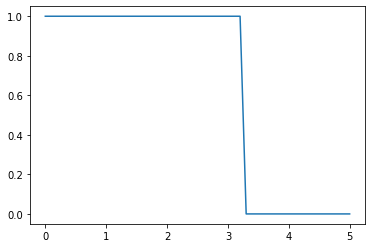

In [33]:
plt.plot(Ulist,np.real(ChernN))

In [34]:
def build_bundle(qstate_list,theta_list,op_list,coef_list,Pstr_list,Nsys):
    circuit_list = []
    N = len(qstate_list)
    N_circ = 0
    for nm in range(N):
        qstate = qstate_list[nm]
        theta = theta_list[nm]
        optlist =op_list[nm]
        coef = coef_list[nm]
        Pstr_arr = Pstr_list[nm]
        NCir = len(coef)
        for nc in range(NCir):
            Nonzero_num = np.count_nonzero(Pstr_arr[nc,:])
            if Nonzero_num==0:
                pass
            else:
                qc = build_circ(qstate,theta,optlist,Pstr_arr[nc,:],Nsys,Nonzero_num)
                circuit_list.append(qc)
                N_circ = N_circ + 1
    return circuit_list, N_circ

def get_result_bundle(num,nshots):
    r=list(num.keys())
    a=list(num.values())
    Nqb = len([ int(s) for s in r[0] ])
    Num_Sta = np.zeros(2**Nqb)
    coe = np.zeros(2**Nqb)
    for j in range(0,len(r)):
        label = [ int(s) for s in r[j] ]
        lab_state = 0
        for m in range(len(label)):
            lab_state = lab_state + 2**m*label[m]
        Num_Sta[lab_state] = a[j]/nshots
        coe[lab_state] =(-1)**(np.sum(label))
    Res = np.dot(coe,Num_Sta)
    return Res

def obtain_bundle(joblist,Numc,nshots):
    result = joblist.result()
    mea_res = np.zeros(Numc,float)
    for n in range(Numc):
        num = result.get_counts(n)
        mea_res[n] = get_result_bundle(num,nshots)
    return mea_res

def obtain_Ulink(meas_resx,Pstr_list,coef_list):
    Np = len(coef_list)
    N_circ = 0
    Ulink = np.zeros(Np,complex)
    for nx in range(Np):
        coef = coef_list[nx]
        OPT = Pstr_list[nx]
        N = len(coef)
        val_c = np.zeros(N,dtype=complex)
        for nm in range(N):
            if np.count_nonzero(OPT[nm,:])==0:
                val_c[nm] = coef[nm]
            else:
                val_c[nm] = coef[nm]*meas_resx[N_circ]
                N_circ = N_circ + 1
        Ulink[nx] = np.sum(val_c)
    return Ulink

In [35]:
import pickle
with open("pstrx", "rb") as fp:
    pstrx_list = pickle.load(fp)
    
with open("pcoex", "rb") as fp:
    pcoex_list = pickle.load(fp)
    
with open("qstatex", "rb") as fp:
    qstatex_list = pickle.load(fp)
    
with open("thetax", "rb") as fp:
    thetax_list = pickle.load(fp)
    
with open("opx", "rb") as fp:
    opx_list = pickle.load(fp)
    
with open("pstry", "rb") as fp:
    pstry_list = pickle.load(fp)
    
with open("pcoey", "rb") as fp:
    pcoey_list = pickle.load(fp)
    
with open("qstatey", "rb") as fp:
    qstatey_list = pickle.load(fp)
    
with open("thetay", "rb") as fp:
    thetay_list = pickle.load(fp)
    
with open("opy", "rb") as fp:
    opy_list = pickle.load(fp)

In [36]:
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

In [37]:
# Error probabilities 010
prob_1 = 0.0002  # 1-qubit gate
prob_2 = 10*prob_1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [ ]:
nshots = 1024*3
Ulist = np.linspace(0, 5, 6)
Chern_0002 = np.zeros((len(Ulist),10),dtype=float)
for nrp in range(10):
    for nu, U in enumerate(Ulist):
        circx, Ncirx = build_bundle(qstatex_list[nu],thetax_list[nu],opx_list[nu],pcoex_list[nu],pstrx_list[nu],4)
        circy, Nciry = build_bundle(qstatey_list[nu],thetay_list[nu],opy_list[nu],pcoey_list[nu],pstry_list[nu],4)
        qobjx=qiskit.transpile(circx,initial_layout=[0,1,2,3])
        jobx = execute(qobjx, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,shots=nshots,noise_model=noise_model)
        qobjy=qiskit.transpile(circy,initial_layout=[0,1,2,3])
        joby = execute(qobjy, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,shots=nshots,noise_model=noise_model)
        measx = obtain_bundle(jobx,Ncirx,nshots)
        Uxc = obtain_Ulink(measx,pstrx_list[nu],pcoex_list[nu])
        measy = obtain_bundle(joby,Nciry,nshots)
        Uyc = obtain_Ulink(measy,pstry_list[nu],pcoey_list[nu])
        Chern_0002[nu,nrp] = get_Chern(kx,ky,Uxc,Uyc)
    print(nrp)

0


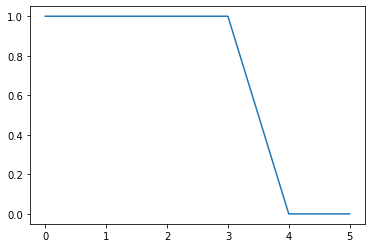

In [39]:
plt.plot(Ulist,np.sum(Chern_0002,axis=1)/10)

In [40]:
Chern_0002[0,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
Chern_0002[1,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [42]:
Chern_0002[2,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
Chern_0002[3,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
Chern_0002[4,:]

array([ 5.30092447e-17,  3.53394965e-17, -3.53394965e-17,  0.00000000e+00,
       -3.53394965e-17, -5.30092447e-17, -1.76697482e-17, -1.76697482e-17,
        3.53394965e-17,  5.30092447e-17])

In [45]:
Chern_0002[5,:]

array([-1.76697482e-17,  1.76697482e-17,  1.76697482e-17, -1.76697482e-17,
        2.65046223e-17, -4.41743706e-17, -3.53394965e-17,  2.65046223e-17,
       -8.83487412e-17, -4.41743706e-17])